# Camera Calibration
1. Calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository.
2. Un-distort one of the calibration images to provide as a demonstration that the calibration is correct

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

# corners in image
nx = 9
ny = 6

#Arrays to store object points and image points
objpoints = []
imgpoints = []

#Prepare object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    #read image
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        imgpoints.append(corners)
        objpoints.append(objp)
        
ret, mtx, dist, revecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save the camera calibration result for later use
dist_dict = {}
dist_dict["mtx"] = mtx
dist_dict["dist"] = dist
pickle.dump( dist_dict, open( "calibration.p", "wb" ) )

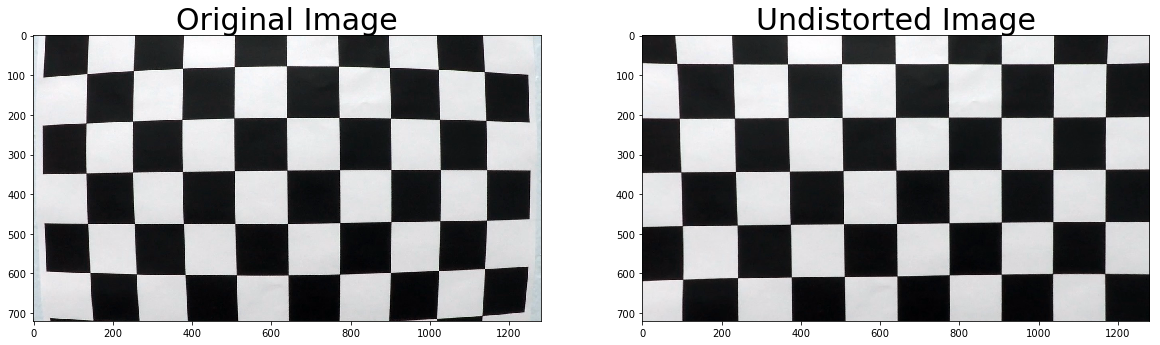

In [2]:
import os.path

# Load the camera calibration result
if os.path.isfile("calibration.p"):
    dist_dict = pickle.load( open("calibration.p", "rb" ) )
    mtx = dist_dict["mtx"] 
    dist = dist_dict["dist"]
else:
    print('Distortion paramers not found.')

# Undistort the first image   
img_distorted = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img_distorted.shape[1], img_distorted.shape[0])
img_undistorted = cv2.undistort(img_distorted, mtx, dist, None, mtx)

#Show the two plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_distorted)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

# Pipeline (Images)
## Step1: Distortion correction on test images
1. Distortion correction that is calculated via camera calibration has been correctly applied to each image. 
2. An example of a distortion corrected image

In [3]:
'''
Function to undistort image
'''
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

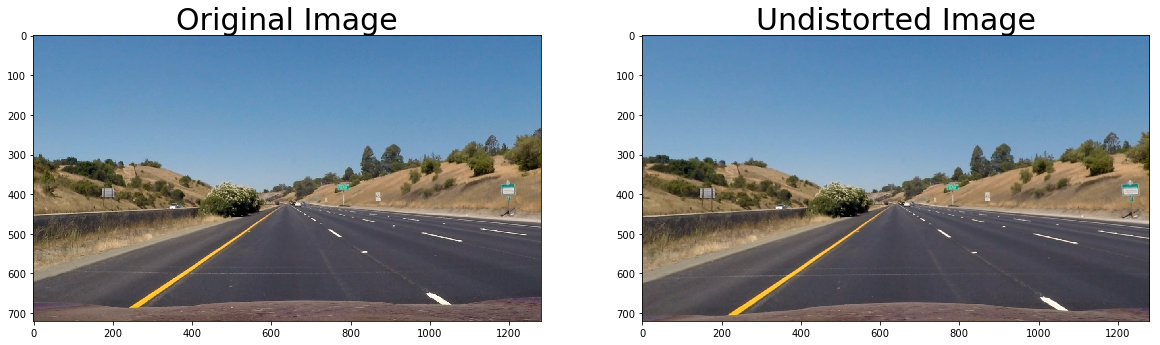

In [4]:
# undistort image using camera calibration parameters
test_img = cv2.imread('./test_images/straight_lines1.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_undist = undistort(test_img, mtx, dist)

#Plot undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_img_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## Step2: Binary image containing lane pixels
1. Visual verification that the pixels identified are part of the lane lines

In [5]:
'''
Function to perform sobel based thresholding
Inputs: mono image, orientation, kernel size and max,min thresholds
Output: Thresholded binary image
'''
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, mag_thresh=(0, 255)):
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if orient=='xy':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        sobel = np.sqrt(sobelx**2 + sobely**2)
    if orient=='x/y':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.arctan2(abs_sobely, abs_sobelx)
        
    if not orient=='x/y':
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary

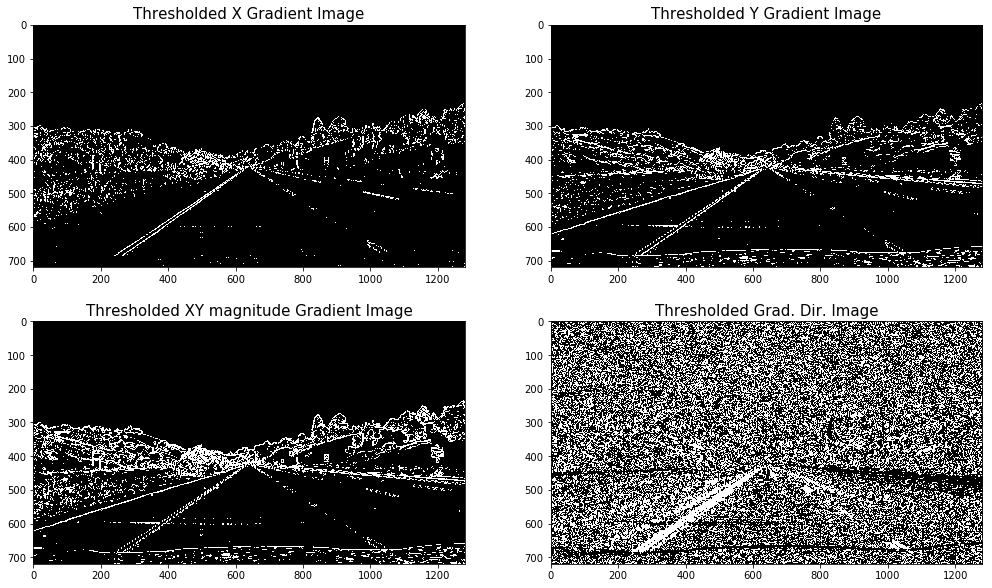

In [6]:
# Run the function
test_img = cv2.imread('./test_images/straight_lines1.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Plot the result
f, ax = plt.subplots(2, 2, figsize=(17,10))

grad_binary = abs_sobel_thresh(cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY), orient='x', mag_thresh=(20, 100))
ax[0,0].imshow(grad_binary, cmap='gray')
ax[0,0].set_title('Thresholded X Gradient Image', fontsize=15)

grad_binary = abs_sobel_thresh(cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY), orient='y', mag_thresh=(20, 100))
ax[0,1].imshow(grad_binary, cmap='gray')
ax[0,1].set_title('Thresholded Y Gradient Image', fontsize=15)

grad_binary = abs_sobel_thresh(cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY), orient='xy', mag_thresh=(20, 100))
ax[1,0].imshow(grad_binary, cmap='gray')
ax[1,0].set_title('Thresholded XY magnitude Gradient Image', fontsize=15)

grad_binary = abs_sobel_thresh(cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY), orient='x/y', sobel_kernel=15, mag_thresh=(0.7, 1.3))
ax[1,1].imshow(grad_binary, cmap='gray')
ax[1,1].set_title('Thresholded Grad. Dir. Image', fontsize=15)

plt.show()

In [7]:
'''
Function to perform sobel based thresholding to detect lanes
    1. First does thresholding in x
    2. Then thresholding in y
    3. Then magnitude thresholding
    4. Then direction thresholding
    5. Takes pixel locations when both x and y detect 1 or both magnitude and direction detect 1.
Inputs: mono image
Output: Thresholded binary image
'''
def apply_sobel_combined(test_img):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(test_img, orient='x', mag_thresh=(5, 200))
    grady = abs_sobel_thresh(test_img, orient='y', mag_thresh=(5, 200))
    mag_binary = abs_sobel_thresh(test_img,  orient='xy', mag_thresh=(5, 200))
    dir_binary = abs_sobel_thresh(test_img, orient='x/y', sobel_kernel=15, mag_thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

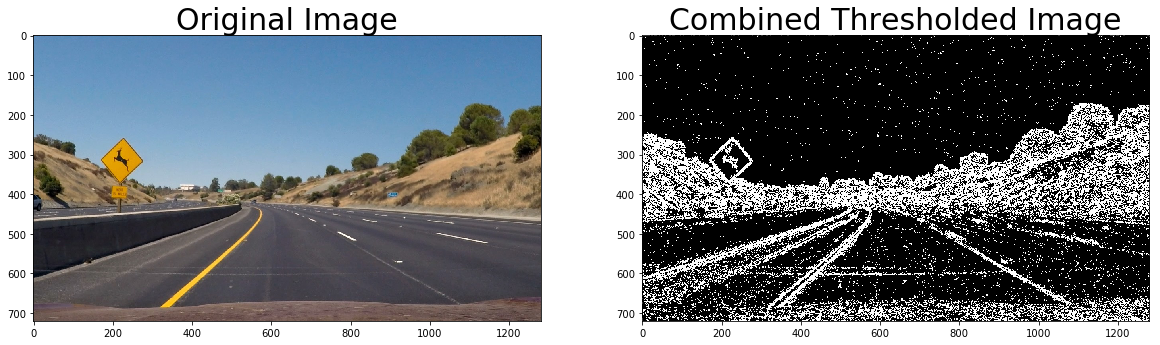

In [8]:
# Test thresholding on an image
test_img = cv2.imread('test_images/test2.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
combined = apply_sobel_combined(cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholded Image', fontsize=30)
plt.show()

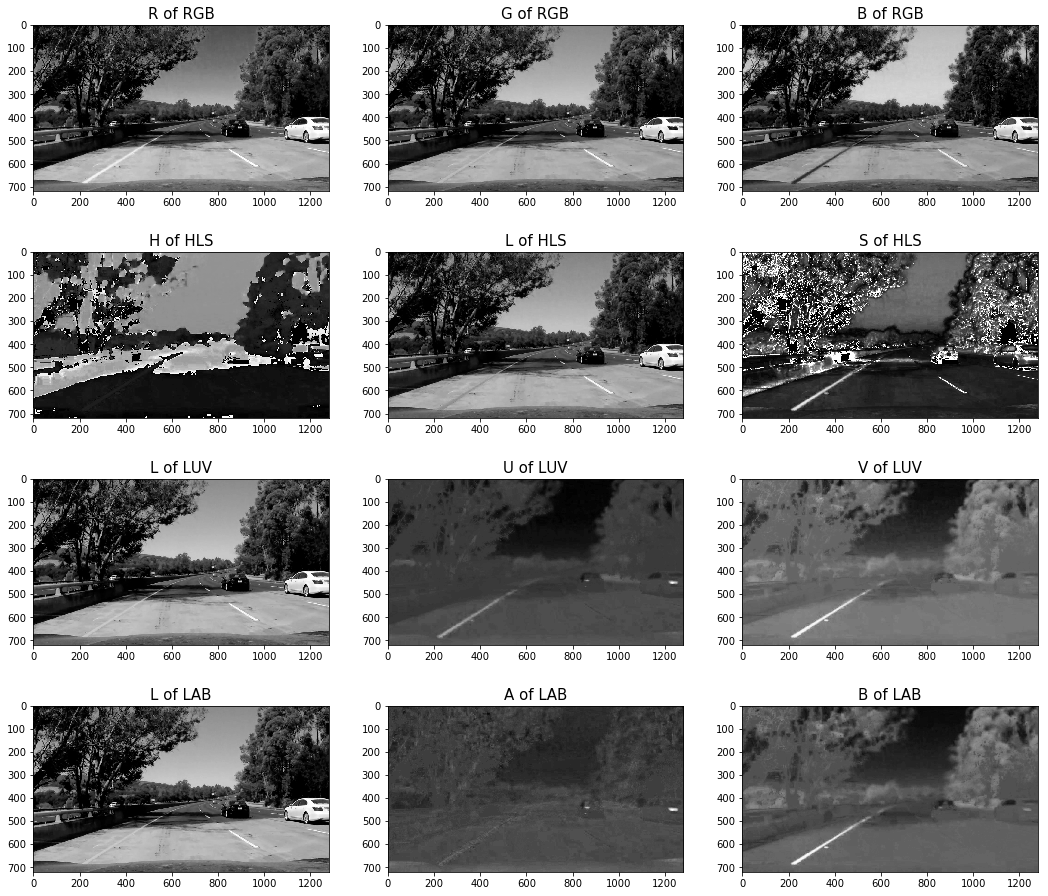

In [9]:
#Test imact of different channels
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Get RGB channels
R_RGB = image[:,:,0]
G_RGB = image[:,:,1]
B_RGB = image[:,:,2]

#Get HLS channels
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H_HLS = hls[:,:,0]
L_HLS = hls[:,:,1]
S_HLS = hls[:,:,2]

#Get LUV channels
luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
L_LUV = luv[:,:,0]
U_LUV = luv[:,:,1]
V_LUV = luv[:,:,2]

#Get Lab channels
lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
L_LAB = lab[:,:,0]
A_LAB = lab[:,:,1]
B_LAB = lab[:,:,2]

#Plot all
f, ax = plt.subplots(4, 3, figsize=(18,16))
ax[0,0].imshow(R_RGB, cmap = 'gray')
ax[0,0].set_title('R of RGB', fontsize=15)
ax[0,1].imshow(G_RGB, cmap = 'gray')
ax[0,1].set_title('G of RGB', fontsize=15)
ax[0,2].imshow(B_RGB, cmap = 'gray')
ax[0,2].set_title('B of RGB', fontsize=15)

ax[1,0].imshow(H_HLS, cmap = 'gray')
ax[1,0].set_title('H of HLS', fontsize=15)
ax[1,1].imshow(L_HLS, cmap = 'gray')
ax[1,1].set_title('L of HLS', fontsize=15)
ax[1,2].imshow(S_HLS, cmap = 'gray')
ax[1,2].set_title('S of HLS', fontsize=15)

ax[2,0].imshow(L_LUV, cmap = 'gray')
ax[2,0].set_title('L of LUV', fontsize=15)
ax[2,1].imshow(U_LUV, cmap = 'gray')
ax[2,1].set_title('U of LUV', fontsize=15)
ax[2,2].imshow(V_LUV, cmap = 'gray')
ax[2,2].set_title('V of LUV', fontsize=15)

ax[3,0].imshow(L_LAB, cmap = 'gray')
ax[3,0].set_title('L of LAB', fontsize=15)
ax[3,1].imshow(A_LAB, cmap = 'gray')
ax[3,1].set_title('A of LAB', fontsize=15)
ax[3,2].imshow(B_LAB, cmap = 'gray')
ax[3,2].set_title('B of LAB', fontsize=15)


plt.show()

It can be observed that
1. S of HLS can detect both white and yellow well
2. L of LUV can also detect white better than yellow
3. B of LAB is doing good job on detecting yellow.

In [10]:
'''
Function to perform color based thresholding
Inputs: mono image
Output: Thresholded binary image
'''
def apply_color_thresholds(img):
    S_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    L_LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    B_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(S_HLS)
    s_binary[(S_HLS >= s_thresh_min) & (S_HLS <= s_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(L_LUV)
    l_binary[(L_LUV >= l_thresh_min) & (L_LUV <= l_thresh_max)] = 1

    b_thresh_min = 147
    b_thresh_max = 200
    b_binary = np.zeros_like(B_LAB)
    b_binary[(B_LAB >= b_thresh_min) & (B_LAB <= b_thresh_max)] = 1
    
    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (l_binary == 1) | (b_binary == 1)] = 1
    
    return combined_binary

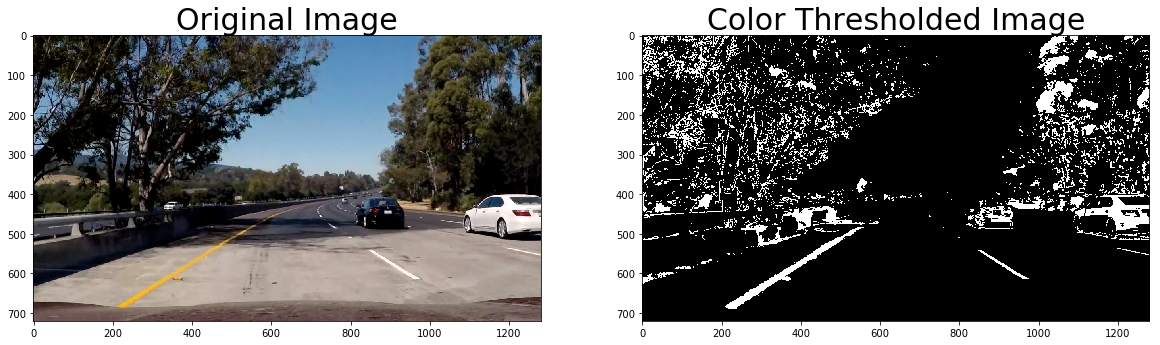

In [11]:
#Test color thresholding on a test image
image_in = cv2.imread('test_images/test5.jpg')
image_in = cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB)

color_thresholded_img = apply_color_thresholds(image_in)
# Plot the result

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_in)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(color_thresholded_img, cmap='gray')
ax2.set_title('Color Thresholded Image', fontsize=30)
plt.show()

For binary thresholding to detect lanes we can use combination of color and sobel thresholding.

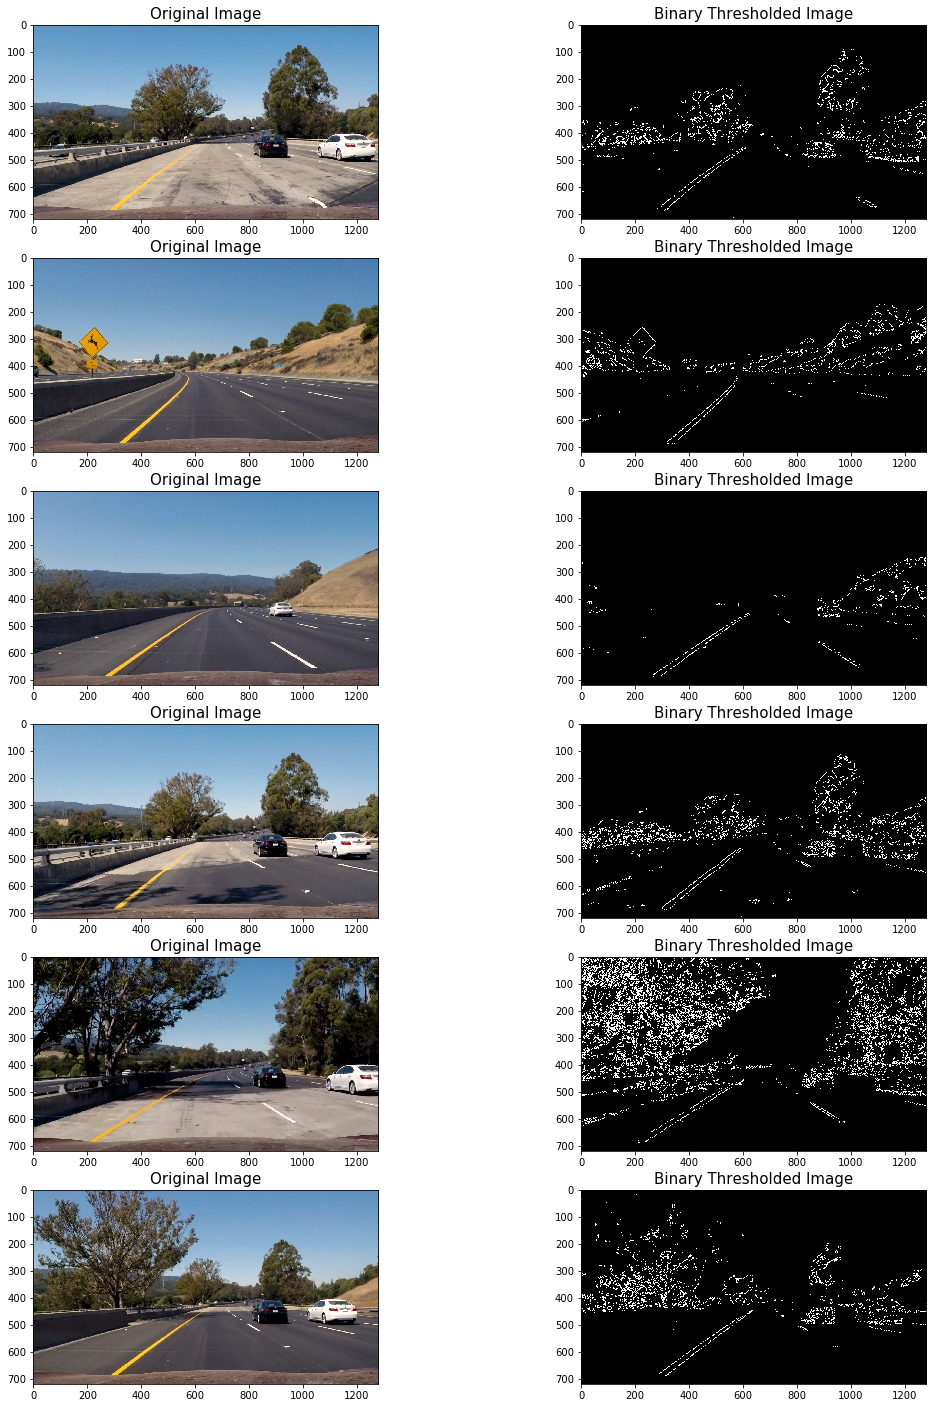

In [12]:
#Test the combined thresholding on all the test images
images = glob.glob('test_images/test*.jpg')

f, ax = plt.subplots(6, 2, figsize=(18,25))

index = 0
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    color_thresholded = color_thresholded = apply_color_thresholds(img)
    img_binary = apply_sobel_combined(color_thresholded)
    
    ax[index,0].imshow(img)
    ax[index,0].set_title('Original Image', fontsize=15)
    ax[index,1].imshow(img_binary, cmap='gray')
    ax[index,1].set_title('Binary Thresholded Image', fontsize=15)
    index += 1
plt.show()

## Step3: Perspective Transform
1. Correctly rectify each image to a "birds-eye view"

In [13]:
'''
Function that Applies an image mask.    
Inputs: image, vertices of mask
Output: Masked image
'''
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

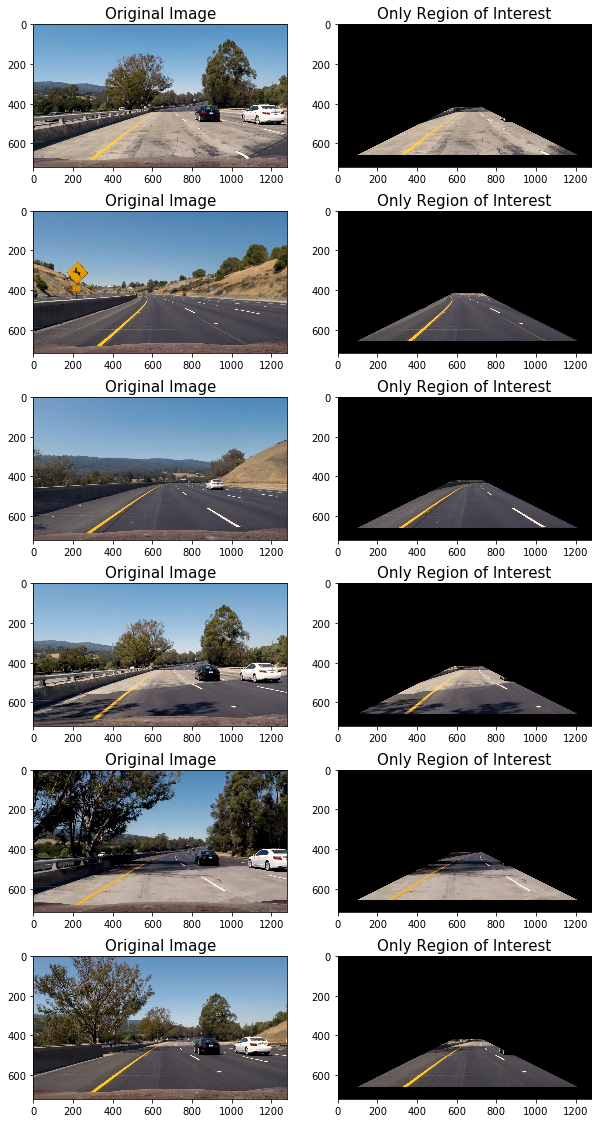

In [14]:
#Test the masking on test images

relevant_mask_polygon = np.array([[(98,658),(1205,658),(722,416),(585,416)]])
# Make a list of calibration images
images = glob.glob('test_images/test*.jpg')

f, ax = plt.subplots(6, 2, figsize=(10,20))

index = 0
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_img_with_region_of_interest = region_of_interest(img, relevant_mask_polygon)
    ax[index,0].imshow(img)
    ax[index,0].set_title('Original Image', fontsize=15)
    ax[index,1].imshow(test_img_with_region_of_interest, cmap='gray')
    ax[index,1].set_title('Only Region of Interest', fontsize=15)
    index += 1
plt.show()

In [15]:
'''
Function that creates birds eye view by warping the perspective
Inputs: image, src polygon, dst polygon
Output: Warped image
'''
def create_birds_eye_view(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

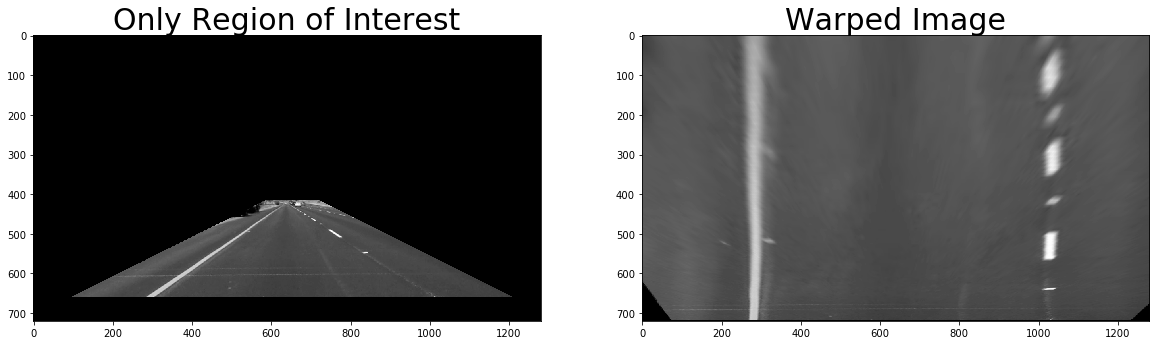

In [16]:
#Test prespetive transform on a test image.
src_perspective = np.float32([[280,669],[1027,669],[679,447],[600,447]])
dst_perspective = np.float32([[280,720],[1027,720],[1027,0],[280,0]])

test_img = cv2.imread('./test_images/straight_lines1.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

test_img_und =  undistort(test_img, mtx, dist)
test_img_with_region_of_interest = region_of_interest(test_img_und, relevant_mask_polygon)
warped_img = create_birds_eye_view(test_img_with_region_of_interest, src_perspective, dst_perspective)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img_with_region_of_interest, cmap = 'gray')
ax1.set_title('Only Region of Interest', fontsize=30)
ax2.imshow(warped_img, cmap = 'gray')
ax2.set_title('Warped Image', fontsize=30)
plt.show()

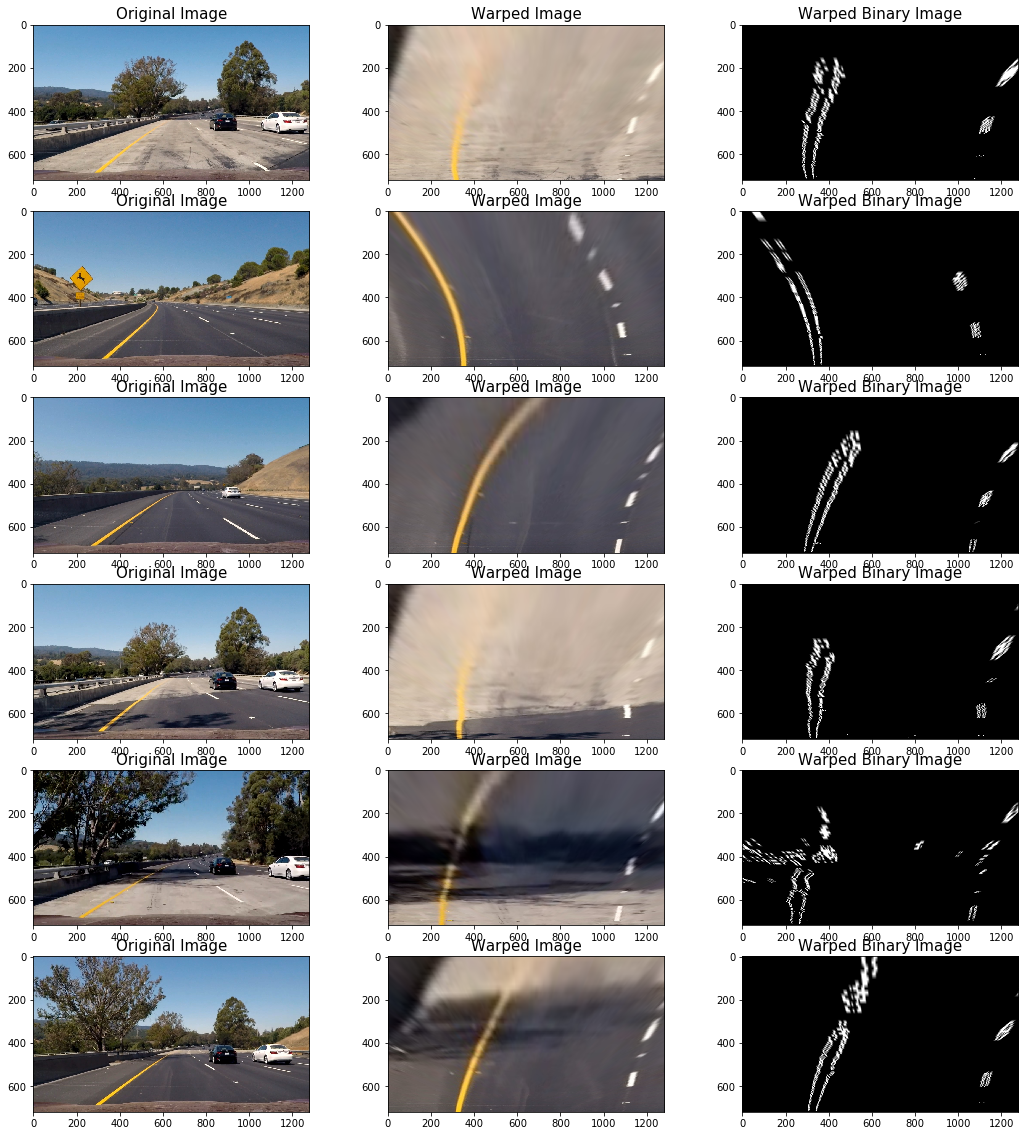

In [17]:
# Test the warping and binary thresholding on test images
images = glob.glob('test_images/test*.jpg')

f, ax = plt.subplots(6, 3, figsize=(18,20))

index = 0
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_undist =  undistort(img, mtx, dist)
    
    color_thresholded = apply_color_thresholds(img_undist)
    
    img_binary = apply_sobel_combined(color_thresholded)
    
    img_interest = region_of_interest(img_binary, relevant_mask_polygon)
    
    warped_img = create_birds_eye_view(img_interest, src_perspective, dst_perspective)
    
    ax[index,0].imshow(img)
    ax[index,0].set_title('Original Image', fontsize=15)
    ax[index,2].imshow(warped_img, cmap='gray')
    ax[index,2].set_title('Warped Binary Image', fontsize=15)
    ax[index,1].imshow(create_birds_eye_view(img_undist, src_perspective, dst_perspective))
    ax[index,1].set_title('Warped Image', fontsize=15)
    index += 1
plt.show()

## Step4: Identify Lanes and Fit Polynomial
1. Identify lane line pixels in the rectified binary image. 
2. Fit with a curved functional form 
3. Plot identified and a fit on example images

In [18]:
'''
Function that identify lanes in an birds eye view image. Uses histogram and windowing based method
Inputs: warped image, windows in y, marin of window, min pix in window to consider good
Output: Indexes of left and right lanes in a non zero matrix and overlayed image showing windows detected
'''
def identify_lanes(binary_warped, nwindows = 12, margin = 120, minpix = 50):
    #define height of window
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    #find non zero elements only
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #consider lower half of image, get column wise sum.
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    #get center point. Should be equal to int(binary_warped.shape[0]/2)
    #get left position in x and y where max points are. These postions will become start of lane. 
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return left_lane_inds, right_lane_inds, out_img

In [19]:
'''
Function to get polynomial fit using left and right lanes using their x,y pixels
Inputs: leftx, lefty, rightx, righty 
Output: Fit coefficients for left and right
'''
def get_poly_fit_both_lanes(leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, out_img

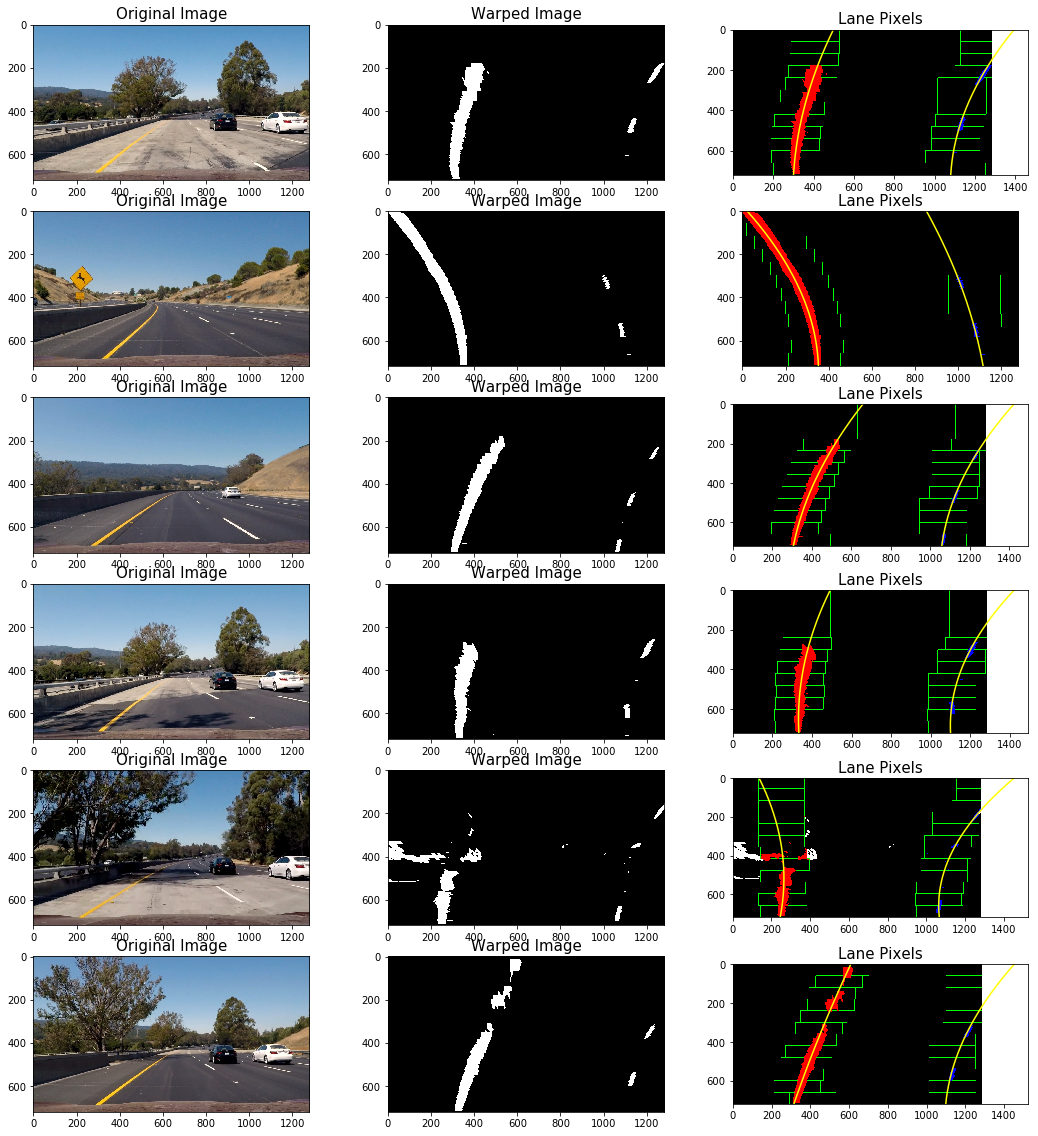

In [22]:
# Test pipeline on images
images = glob.glob('test_images/test*.jpg')

f, ax = plt.subplots(6, 3, figsize=(18,20))

index = 0
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_undist =  undistort(img, mtx, dist)
    
    img_binary = apply_color_thresholds(img_undist)
    
    #img_binary = apply_sobel_combined(color_thresholded)
    
    img_interest = region_of_interest(img_binary, relevant_mask_polygon)
    
    warped_img = create_birds_eye_view(img_interest, src_perspective, dst_perspective)
    
    left_lane_inds, right_lane_inds, out_img = identify_lanes(warped_img)
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit, right_fit, out_img = get_poly_fit_both_lanes(leftx, lefty, rightx, righty)
      
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    ax[index,0].imshow(img)
    ax[index,0].set_title('Original Image', fontsize=15)
    
    ax[index,1].imshow(warped_img,cmap = 'gray')
    ax[index,1].set_title('Warped Image', fontsize=15)
    
    ax[index,2].imshow(out_img)
    ax[index,2].plot(left_fitx, ploty, color='yellow')
    ax[index,2].plot(right_fitx, ploty, color='yellow')
    ax[index,2].set_title('Lane Pixels', fontsize=15)
    index += 1
plt.show()

### Step5: Radius of Curvature and Distance From Lane Center
1. Calculate the radius of curvature of the lane 
2. Estimate the position of the vehicle with respect to center.

In [23]:
'''
Function to get Radius of Curvature for each lane line
Input: x and y pixels for both lanes.
Ouptut: left and right curvatures
'''
def get_radius_of_curvature(leftx, lefty, rightx, righty):
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(righty) + right_fit_cr[1])**2)**1.5) /np.absolute(2*right_fit_cr[0])
    
    return  left_curverad, right_curverad 


In [24]:
'''
Function to get distance from center of lane
Input: polynomial fits for left and right lanes
Ouptut: distance from center
'''
# Calculate the position of the vehicle
def get_center_position(left_fit, right_fit):
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    center  = 640-((rightx_int+leftx_int)/2)
    return center

In [25]:
'''
Function to add text on image
Input: image, location where to add, list with text, font size
Ouptut: image with added text
'''
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

def add_info_on_image(image, location, info, font_size):
    img = Image.fromarray(image, 'RGB')
    font = ImageFont.truetype("arial.ttf", font_size)
    
    line_count = 0
    for text_string in info:
        draw = ImageDraw.Draw(img)
        draw.text((location[0], location[1] + font_size*line_count),text_string,(255,255,255),font=font)
        line_count += 1
    
    imgage_as_array = np.asarray( img, dtype="uint8" )
    imgage_as_array.setflags(write=1)
    return imgage_as_array    

### Final pipeline is follows
1. Undistort the image
2. Apply binary thresholding using color (I tried sobel based as well but no gain was found, so dropped it)
3. Get region of interest
4. Get warped image by applying perspective transformation
5. Using histogram and windowing based method identify lanes.
6. Using the identified pixels, fit 2nd order polynomial.
7. Using the polynomial, get radius of curvature and distance from center.

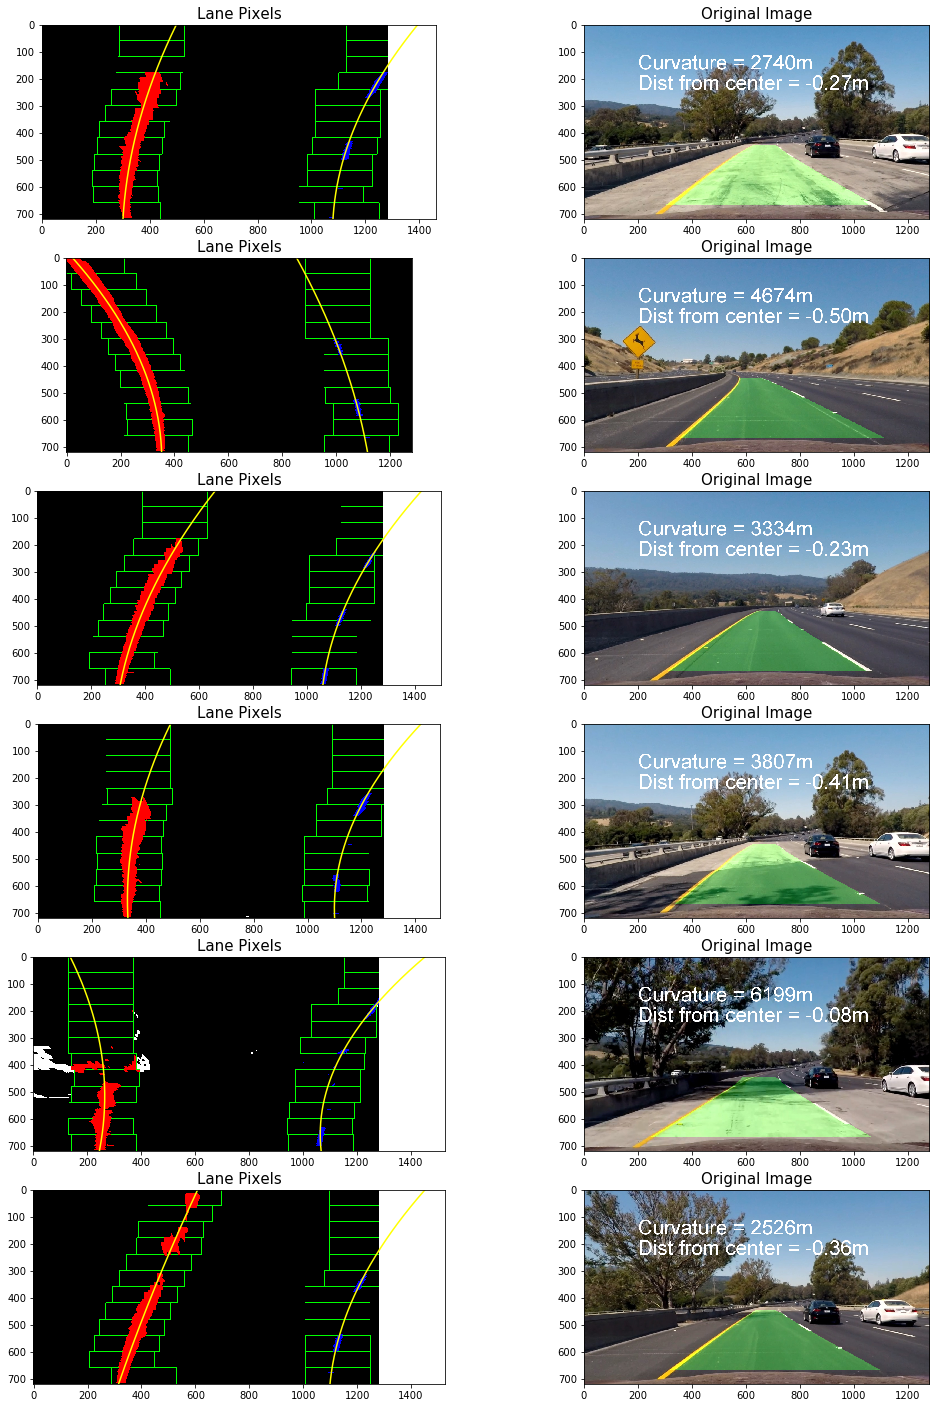

In [28]:
# Test pipeline on test images
images = glob.glob('test_images/test*.jpg')

f, ax = plt.subplots(6, 2, figsize=(17,25))

index = 0
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_undist =  undistort(img, mtx, dist)
    
    img_binary = apply_color_thresholds(img_undist)
    
    #img_binary = apply_sobel_combined(color_thresholded)
    
    img_interest = region_of_interest(img_binary, relevant_mask_polygon)
    
    warped_img = create_birds_eye_view(img_interest, src_perspective, dst_perspective)
    
    left_lane_inds, right_lane_inds, out_img = identify_lanes(warped_img)
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit, right_fit, out_img = get_poly_fit_both_lanes(leftx, lefty, rightx, righty)
      

    left_curverad, right_curverad = get_radius_of_curvature(leftx, lefty, rightx, righty)
    w_left = len(np.unique(lefty))/(len(np.unique(lefty)) + len(np.unique(righty)))
    w_right = 1.0-w_left
    curvature = w_left*left_curverad + w_right*right_curverad
    
    lane_center = get_center_position(left_fit, right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    color_warp = np.zeros_like(img).astype(np.uint8)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst_perspective, src_perspective)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    info = []
    info.append('Curvature = {}m'.format(int(curvature)))
    info.append('Dist from center = {:.2f}m'.format(lane_center*3.7/700))
    img = add_info_on_image(result, (200,100), info, 75)
    
    
    ax[index,1].imshow(img)
    ax[index,1].set_title('Original Image', fontsize=15)
    
    ax[index,0].imshow(out_img)
    ax[index,0].plot(left_fitx, ploty, color='yellow')
    ax[index,0].plot(right_fitx, ploty, color='yellow')
    ax[index,0].set_title('Lane Pixels', fontsize=15)
    
    index += 1
plt.show()

# Pipeline (Video)

### Following ideas are used 
1. For every frame, calculate difference in curvature, how parallel they are and distance between them.
2. Using these parameters decide if current frame has good lane detection or not.
3. If yes, then check if either right lane is bad or left.
4. Depending on how much the coeffecients of fit have changed compared to previous frame, decide if current frame is good or not. This is done for left and right lanes separately.
5. Depending on if either is good or bad, update in history for each lane accordingly.
6. If the lane is detected as bad, the measurement is not kept in history and a counter is increased counting how many frames were bad in past. If this counter goes beyond a threshold, complete history dropped and algorithm starts fresh.
7. If the lane is detected as good, the measurement is added to history. There is a maximum length on history and as more new measurements come in, older are dropped.
8. Final output is given as average over history.
9. In history, polynomial coefficients and x positions from the fit are stored. For best current estimate, average over the history is taken.

In [25]:
'''
Class to keep track of parameters for each lane
'''
class Line():
    #Define max history and reset threshold
    max_queue_len = 10
    reset_count = 7
    
    '''
    Function to initialize class.
    Input: None
    Output: None
    '''
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients of the fitted line over the last n iterations
        self.recent_poly = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([0,0,0])  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Count of frames where lane not visible
        self.non_visible = 0
        
        self.first_frame_received = False
        
    
    '''
    Function to update the parameters using the estimates from current frame
    Input: curvature, x indeces, y indeces of estimate, fit coefficients, center
    Output: None
    '''
    def update_current_params(self, curverad, allx, ally, fit, center):
        self.diffs = self.current_fit - fit
        self.current_fit = fit
        self.radius_of_curvature = curverad
        self.allx = allx
        self.ally = ally
        self.line_base_pos = center
        if not self.first_frame_received:
            ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
            fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]
            self.first_frame_received = True
            self.recent_poly = self.current_fit.reshape(1,3)
            self.recent_xfitted = fitx.reshape(1,720)
        
        
    '''
    Function to update the parameters if current measurement is found to be good
    Input: None
    Output: None
    '''
    def update_as_good(self):
        self.detected = True
        
        ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
        fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]

        #Update poly queue
        self.recent_poly = np.concatenate((self.recent_poly,self.current_fit.reshape(1,3)), axis = 0)
        #Update xfitted queue
        self.recent_xfitted = np.concatenate((self.recent_xfitted,fitx.reshape(1,720)), axis = 0)
        
        #If max length is achieved, remove oldest
        if self.recent_poly.shape[0] > self.max_queue_len:
            self.recent_poly = self.recent_poly[1:,:]
            self.recent_xfitted = self.recent_xfitted[1:,:]
        
    '''
    Function to update the parameters if current measurement is found to be bad
    Input: None
    Output: None
    '''
    def update_as_bad(self):
        self.detected = False
        self.non_visible += 1
        
        #If non visible frames are more then reset, keep only the latest in queue
        if self.non_visible > self.reset_count:
            self.recent_poly = self.recent_poly[-1,:].reshape(1,3)
            self.recent_xfitted = self.recent_xfitted[-1,:].reshape(1,720)
      
    '''
    Function to get best polynomial estimate
    Input: None
    Output: best polynomial estimate
    '''
    def get_best_poly(self):
        self.best_fit = np.mean(self.recent_poly, axis = 0)
        return self.best_fit
        
    '''
    Function to get best xfit
    Input: None
    Output: best xfit
    '''
    def get_best_x(self):
        self.bestx = np.mean(self.recent_xfitted, axis = 0)
        return self.bestx

In [26]:
'''
Function to check if detection in current frame is good or bad. And if bad which lane is bad
    1. Estimate difference in curvature, non parallelism, error in size
    2. Depending on the above parameters decide if current measurement is bad.
    3. In case it is bad, check for left and right lane separately.
    4. The above is done by check if the change in values of polynomial coefficients is less than a threshold.
Input: left curvature,right curvature, coeff of left fit, coeff of right fit, change in coeff of left fit, change in coeff of right fit
Output: boolian if left and line are bad or not
'''
def check_status_of_detection(left_curverad, right_curverad, left_fit, right_fit, left_diffs, right_diffs):
    curve_diff_max = 8000;
    non_parallelsim_thresh = 0.25;
    max_dist_error = 27;

    coeff1_max_diff = 0.0002;
    coeff2_max_diff = 0.25;
    coeff3_max_diff = 100;

    curvature_diff = np.abs(left_curverad - right_curverad); 
    d_y720 = (left_fit[0]*(720^2) + left_fit[1]*720 + left_fit[2]) - (right_fit[0]*(720^2) + right_fit[1]*720 + right_fit[2]);
    d_y0 = left_fit[2] - right_fit[2];
    non_parallelism = np.abs(1-d_y720/d_y0);
    distance_error = abs(-760-d_y720);
    
    if curvature_diff > curve_diff_max or non_parallelism > non_parallelsim_thresh or distance_error > max_dist_error:
        red_flag = True
    else:
        red_flag = False
        
    if red_flag:
        if left_diffs[0] > coeff1_max_diff or left_diffs[1] > coeff2_max_diff or left_diffs[2] > coeff3_max_diff:
            red_flags_left = True
        else:
            red_flags_left = False
        
        if right_diffs[0] > coeff1_max_diff or right_diffs[1] > coeff2_max_diff or right_diffs[2] > coeff3_max_diff:
            red_flags_right = True
        else:
            red_flags_right = False
    else:
        red_flags_left = False
        red_flags_right = False
    return red_flags_left, red_flags_right

### Final pipeline of video looks as follows
1. Undistort the image
2. Apply binary thresholding using color (I tried sobel based as well but no gain was found, so dropped it)
3. Get region of interest
4. Get warped image by applying perspective transformation
5. Using histogram and windowing based method identify lanes.
6. Using the identified pixels, fit 2nd order polynomial.
7. Using the polynomial, get radius of curvature and distance from center.
8. Using polynomial, and raidus of curvature estimate from both lanes, estimate difference in curvature, non parallelism, error in size
9. If above parameters are not ideal, then check for each lane separately if the change in values of polynomial coefficients is less than a threshold and using this result identify if current measurement for each lane is good or bad.
10. Update the measurements accordingly.
11. Get smoothened values of poly coefficients for each lane and x fit.
12. Using the coefficients and x fit get new curvature and distance from center.


In [29]:
'''
Function to detect lanes in a video
Input: image from current frame, Lane objects for Left and right lanes.
Output: image with visualization and updated Lane objects for Left and right lanes
'''
def lane_detect_pipeline(img, Left, Right, smoothening_on = True):
    #Undistort
    img_undist =  undistort(img, mtx, dist)
    
    #Create binary image
    img_binary = apply_color_thresholds(img_undist)
    #img_binary = apply_sobel_combined(color_thresholded)
    
    #Extract region of interest
    img_interest = region_of_interest(img_binary, relevant_mask_polygon)
    
    #warp image to create birds eye view
    warped_img = create_birds_eye_view(img_interest, src_perspective, dst_perspective)
    
    #Get left and right lane indeces
    left_lane_inds, right_lane_inds, out_img = identify_lanes(warped_img)
    
    #Get fit values, curvature and distance from center
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit, right_fit, out_img = get_poly_fit_both_lanes(leftx, lefty, rightx, righty)
    left_curverad, right_curverad = get_radius_of_curvature(leftx, lefty, rightx, righty)
    lane_center = get_center_position(left_fit, right_fit)
    
    #Update lanes using fit values, curvature and distance from center
    Left.update_current_params(left_curverad, leftx, lefty, left_fit, lane_center)
    Right.update_current_params(right_curverad, rightx, righty, right_fit, lane_center)
    
    #Check status of detection
    red_flags_left, red_flags_right = check_status_of_detection(
        left_curverad, right_curverad, left_fit, right_fit, Left.diffs, Right.diffs)
    
    #Depending on status of detection update lanes
    if red_flags_left:
        Left.update_as_bad()
    else:
        Left.update_as_good()
    
    if red_flags_right:
        Right.update_as_bad()
    else:
        Right.update_as_good()
        
    #Get smoothened values 
    if smoothening_on:
        left_fit_smooth = Left.get_best_poly()
        right_fit_smooth = Right.get_best_poly()

        left_fitx_smooth = Left.get_best_x()
        right_fitx_smooth = Right.get_best_x()
    else:
        left_fit_smooth = left_fit
        right_fit_smooth = right_fit
        
        left_fitx_smooth = leftx
        right_fitx_smooth = lefty
    
    #Get points to plot using smooth left and right fits
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    left_fitx_smooth = left_fit_smooth[0]*ploty**2 + left_fit_smooth[1]*ploty + left_fit_smooth[2]
    right_fitx_smooth = right_fit_smooth[0]*ploty**2 + right_fit_smooth[1]*ploty + right_fit_smooth[2]
    
    #Get smooth curvature and distance using left and right fits
    if smoothening_on:
        left_curverad, right_curverad = get_radius_of_curvature(left_fitx_smooth, ploty, right_fitx_smooth, ploty)
        lane_center = get_center_position(left_fit_smooth, right_fit_smooth)
    
    curvature = 0.5*left_curverad + 0.5*right_curverad
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx_smooth, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx_smooth, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    color_warp = np.zeros_like(img).astype(np.uint8)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst_perspective, src_perspective)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)

    #Add info about curvature and distance
    info = []
    info.append('Curvature = {}m'.format(int(curvature)))
    info.append('Dist from center = {:.2f}m'.format(lane_center*3.7/700))
    result = add_info_on_image(result, (200,100), info, 50)
    
    return result, Left, Right

In [35]:
#Read video frame by frame and detect lane using the lane detection pipeline

Left = Line()
Right = Line()

#Define input video object
cap = cv2.VideoCapture("project_video.mp4")

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('project_video_output.mp4',fourcc, 20.0, (img.shape[1], img.shape[0]))

frames_read = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frames_read += 1
        result, Left, Right = lane_detect_pipeline(frame, Left, Right)
        out.write(result)
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

In [33]:
from IPython.display import HTML
lane_output = './project_video_output.mp4'
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(lane_output))

In [48]:
#Create another video without smoothenening and merge it with smoothened video

Left = Line()
Right = Line()

#Define input video object
cap = cv2.VideoCapture("project_video.mp4")

#Define input video object to be merged
cap_output = cv2.VideoCapture("project_video_output.mp4")

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('project_video_output_merged.mp4',fourcc, 20.0, (img.shape[1]*2, img.shape[0]))

frames_read = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    ret_out, frameRight = cap_output.read()
    if ret == True or ret_out == True:
        frames_read += 1
        result, Left, Right = lane_detect_pipeline(frame, Left, Right, False)
        new_image = np.concatenate((result,frameRight), axis=1)
        new_image = add_info_on_image(new_image, (200,10), ['No Smoothing'], 50)
        new_image = add_info_on_image(new_image, (img.shape[1]+200,10), ['Smoothing'], 50)
        #new_image = cv2.resize(blank_image, (0,0), fx=0.5, fy=0.5) 
        out.write(new_image)
    else:
        break

# Release everything if job is finished
print(frames_read)
cap.release()
out.release()
cap_output.release()
cv2.destroyAllWindows()

1257


In [34]:
from IPython.display import HTML
lane_output = './project_video_output_merged.mp4'
HTML("""
<video width="24160" height="720" controls>
  <source src="{0}">
</video>
""".format(lane_output))